**Main Libraries**

In [82]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Numerical libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Statistics and Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

**Loading Data**

In [15]:
df_out = pd.read_csv('LSTM_output.csv')
df_out = df_out[['rollRate','pitchRate','yawRate','anomaly27']].tail(int(0.25*len(df_out)))
df_out

,rollRate,pitchRate,yawRate,anomaly27
27000,-0.1,-0.1,0.0,0
27001,0.1,0.0,0.0,0
27002,0.2,-0.0,0.2,0
27003,-0.3,-0.5,0.0,0
27004,1.7,0.4,-4.7,0
...,...,...,...,...
35994,-0.0,0.2,-0.1,0
35995,-0.1,0.2,0.1,0
35996,-0.0,-0.0,0.0,0
35997,-0.0,-0.1,0.1,0


In [19]:
df_out.anomaly27.value_counts()

0    6799
1    2200
Name: anomaly27, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5254188d0>,
      dtype=object)

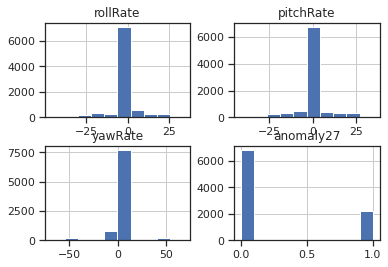

In [17]:
df_out.hist()

**X, y matrices**

In [22]:
X = df_out[['rollRate','pitchRate','yawRate']]
y = df_out[['anomaly27']]

print(X.head(),'\n\n',y.head())

       rollRate  pitchRate  yawRate
27000      -0.1       -0.1      0.0
27001       0.1        0.0      0.0
27002       0.2       -0.0      0.2
27003      -0.3       -0.5      0.0
27004       1.7        0.4     -4.7 

        anomaly27
27000          0
27001          0
27002          0
27003          0
27004          0


In [24]:
X_train,X_test,\
y_train,y_test = train_test_split(X,y,test_size=0.05,random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8549, 3)
(450, 3)
(8549, 1)
(450, 1)


**Classifier**

In [114]:
# Hyperparameters tunning
hyperparameters = {
    "learning_rate":[0.05, 0.1, 0.2, 0.5, 0.9],
    "n_estimators":[20, 50, 100, 200, 300, 500, 700, 1000],
    "max_depth":[3, 5, 10, 15, 20, 30],
    "min_samples_split":[2, 4, 7, 10],
    "min_samples_leaf":[1, 2, 3, 5, 8, 10],
    "min_impurity_decrease":[0., 0.2, 0.4, 0.5, 0.6, 0.8, 1.],
    "max_leaf_nodes":[5, 10, 20, 30, 50, 100, 300]
}

# Create a baseline model
model = GradientBoostingClassifier()

# Instantiate the params grid search model
randomized_search = RandomizedSearchCV(model, hyperparameters, random_state=42, n_iter=5, scoring=None,
                                       n_jobs=-1, refit=True, cv=5, verbose=True,return_train_score=True)

# Fit the grid search to the data
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.5,
                                                          0.9],
                                        'max_depth': [3, 5, 10, 15, 20, 30],
                                        'max_leaf_nodes': [5, 10, 20, 30, 50,
                                                           100, 300],
                                        'min_impurity_decrease': [0.0, 0.2, 0.4,
                                                                  0.5, 0.6, 0.8,
                                                                  1.0],
                                        'min_samples_leaf': [1, 2, 3, 5, 8, 10],
                                        'min_samples_split': [2, 4, 7, 10],
                                        'n_estimators': [20, 50, 100, 200, 300,
                                                        

In [102]:
hyperparameters_tuning = randomized_search
print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

Best Parameters = {'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.2, 'max_leaf_nodes': 50, 'max_depth': 15, 'learning_rate': 0.2}


In [175]:
classifier = GradientBoostingClassifier(n_estimators=500,min_samples_split=10,min_samples_leaf=10,
                                                           min_impurity_decrease=0.2,max_leaf_nodes=50,max_depth=100,
                                                           learning_rate=0.05,criterion='friedman_mse')
classifier = classifier.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [176]:
y_pred = classifier.predict(X_test)
y_pred = pd.DataFrame({'anomalyFlag':list(y_pred)})
y_pred

,anomalyFlag
0,1
1,1
2,0
3,0
4,1
...,...
445,0
446,1
447,0
448,0


In [177]:
f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, y_pred)*100,2)
precision = round(precision_score(y_test, y_pred)*100,2)
recall = round(recall_score(y_test, y_pred)*100,2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

F1 Score: 76.86%
Accuracy Score: 83.56%
Precision Score: 76.14%
Recall Score: 55.83%


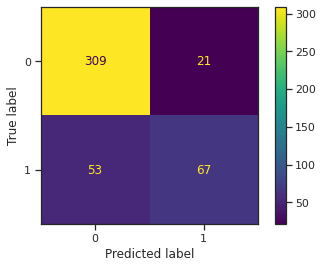

In [178]:
plot_confusion_matrix(classifier, X_test, y_test, values_format='d')  
plt.grid(False)
plt.show()

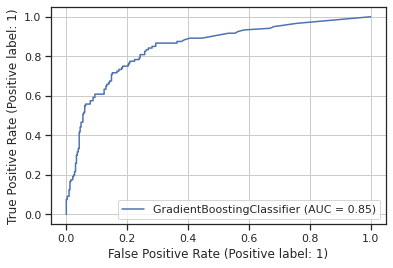

In [179]:
plot_roc_curve(classifier, X_test, y_test)  
plt.grid(True)
plt.show()

**Exporting the Model**

In [181]:
# saving the model (joblib)
import joblib
filename = 'anomalyDetector.joblib'
joblib.dump(classifier, filename)

['anomalyDetector.joblib']

In [182]:
# loading the model (joblib)
filename = 'anomalyDetector.joblib'
loaded_model = joblib.load(filename)
loaded_model

GradientBoostingClassifier(learning_rate=0.05, max_depth=100, max_leaf_nodes=50,
                           min_impurity_decrease=0.2, min_samples_leaf=10,
                           min_samples_split=10, n_estimators=500)

In [183]:
# Example of data to take as input to the model
X.iloc[5]

rollRate     0.3
pitchRate    0.0
yawRate      0.8
Name: 27005, dtype: float64

In [184]:
X.iloc[[5]].values #input values

array([[0.3, 0. , 0.8]])

In [185]:
model_input = X.iloc[[5]].values
model_output = loaded_model.predict(model_input)
model_output

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([0])